In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from scipy.optimize import differential_evolution

In [8]:
#colors
DARK_RED = '#b30000'
RED = '#ff0000'
GRAY = '#bfbfbf'
BLUE = '#4d94ff'
DARK_BLUE = '#0066ff'

## Links
- Media Sources by Dem/Rep: https://www.journalism.org/2020/01/24/americans-are-divided-by-party-in-the-sources-they-turn-to-for-political-news/
- Most common platform for news by Dem/Rep: https://www.journalism.org/2020/01/24/election-news-pathways-project-frequently-asked-questions/#ideological-composition-of-news-outlets-audiences
- News from social media 2021: https://www.pewresearch.org/fact-tank/2021/01/12/more-than-eight-in-ten-americans-get-news-from-digital-devices/
- Number of sources by Dem/Rep: https://www.pewresearch.org/pathways-2020/MAINSOPOL_USE/political_party/us_adults
- News from social media 2020: https://www.journalism.org/2020/07/30/americans-who-mainly-get-their-news-on-social-media-are-less-engaged-less-knowledgeable/
- Most common platform by Dem/Rep: https://www.pewresearch.org/pathways-2020/NEWS_MOST/political_party/us_adults
- Paper about Social Media and news consumption: https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.20191777
- Daily news consumption: https://www.americanpressinstitute.org/publications/reports/survey-research/americans-news-consumption/

In [9]:
#make media classes
class MediaOutlet:
    def __init__(self, name, political_leaning, mcb_ideology):#, mcb_education, mcb_age)
        self.name = name
        self.political_leaning = political_leaning#[dem, Dlean, mod, Rlean, rep]  0 or 1 by what media place is
        
        #Media Consumption by...
        self.mcb_ideology = mcb_ideology#[dem, Dlean, Rlean, rep]  % of that group that consumes
        #self.mcb_education #[college +, some college, HS -]  % of that group that consumes
        #self.mcb_age # [18-49, 50+]  % of that group that consumes
    
    def __str__(self):
        return self.name
     
    def get_value(self):
        values = [-1, -0.5, 0, 0.5, 1]
        return values[self.political_leaning.index(1)]
#     def __add__(self, other):
        
    

In [10]:
#make agent class
class Agent:
    def __init__(self, approval, ideology, approval_value):
        self.media_consumption = []
        self.consumption_rate = 0

        #demographic information
        self.approval = approval
        self.ideology = ideology
        
        self.approval_value = approval_value
        
        #self.neg_persuadability = abs(1 - approval_value)/2
        #self.pos_persuadability = abs(-1 - approval_value)/2
        
        #using this set up gives us a steeper curve than above and also accounts for values outside of the bounds -1, 1
            #at 0 the persuadability is 0.269 rather then 0.5
        denom = np.exp(2)-1
        self.neg_persuadability = (np.exp(-approval_value+1)-1)/denom
        self.pos_persuadability = (np.exp(approval_value+1)-1)/denom
        
        self.uses_social_media = False
        
        self.late_night = 0
       
    
    def assign(self, media_outlet):
        self.media_consumption.append(media_outlet)
        
        
    def stats(self):
        print(f'Ideology: {self.ideology}\nApproval: {self.approval}')

        print('\tMedia Sources: ', end='')
        for m in self.media_consumption:
            print(m, end=', ')
        
        print(f'\n\tConsumption Frequency: {self.consumption_rate}', end='')
        
        oftenness = ['Never', 'Less than Once a Month', 'About Once a Month', 'Several Times a Month', 'Once a Week', 'Multiple Times A Week']
        print(f'\nWatches Late-Night: {oftenness[self.late_night]}')
            
    def consume_media(self):
        #return all the media the was conusmed this step
            #perhaps the raw value
        return [m.get_value() for m in self.media_consumption]

In [125]:
class Model:
    def __init__(self, num_agents, political_distribution, approval_matrix, media_array, distribution_threshold=0.1, platform_split=[[], []], use_late_night=False):
                                                                                                                    # %dem, %rep who use social media for news
        self.political_distribution = political_distribution 
            #[%, %, %] (for now, [D, R, indep])distrib of agents ideologies
            
        self.approval_matrix = np.array(approval_matrix)
        
            #[Dem, Rep, Ind] by [strongly app, somewhat app, somewhat disapp, strongly disapp, no approval]
                #matrix 
        
        self.media_array = media_array 
            #array of MediaOutlet objects to loop through
        
        self.platform_split = platform_split
        # %dem, %rep who use social media for news
        
        self.use_late_night = use_late_night
        #parameters
#         self.threshold = threshold
#         self.alpha = alpha
        
        #make the agents
        self.agents = [None]*num_agents
        self.agent_approval_values = np.zeros((num_agents, ))
        self.agent_political_ids = np.zeros((num_agents, 4))
        
        self.generate_agents(num_agents, distribution_threshold)
        
        self.starting_state = self.agent_approval_values.copy()
        self.starting_agent_op = [str(agent.approval) for agent in self.agents]
        
        
    def generate_agents(self, num_agents, distribution_threshold):
        #initialize agents with ideology and approval
            #approval is a continuous value normally distributed around the 4 poles within some threshold
        
        
        distribution = np.round(self.approval_matrix * self.political_distribution * num_agents / 10000)
        #other = num_agents - np.sum(distribution)
        
        current_agent = 0
        approval_types = ['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion']
        self.approval_types = np.array(approval_types)
        approval_values = [1, 0.5, -0.5, -1, 0]
        party_types = ["democrat", 'republican', 'independent']
        politcal_ids = [[[1, 0, 0, 0], [0, 1, 0, 0]],
                        [[0, 0, 1, 0], [0, 0, 0, 1]],
                        [[0, 1, 0, 0], [0, 0, 1, 0]]]
        random_choices = np.random.randint(low=0, high=2, size=(num_agents,))
        for index, approval_row in enumerate(distribution):
            for party_index, amount in enumerate(approval_row):
                amount = int(amount)
                #normal distribution within threshold of the index 
                
                self.agent_approval_values[current_agent:current_agent+amount] = np.random.normal(approval_values[index], distribution_threshold/3, (amount,)) 
                '''The party IDs are chosen randomly within each party, where the intensity of approval values should probably dictate if someone is lean left versus far left
                        - or maybe not, since this is conflating Trump approval with party alignment. 
                        - a lean left person may disapprove of trump, while a far left may approve of him slightly more'''
                self.agent_political_ids[current_agent:current_agent+amount] =  [politcal_ids[party_index][val] for val in random_choices[current_agent:current_agent+amount]]
                
                self.agents[current_agent:current_agent+amount] = [Agent(approval_types[index], party_types[party_index], self.agent_approval_values[current_agent+i]) for i in range(amount)]
                current_agent += amount

        
        #calculate the needed assignments to reach the percentages
        
        approvals = np.histogram([list(self.approval_types).index(agent.approval) for agent in self.agents[:current_agent]], bins=len(self.approval_types))[0]
        
        #force this for now
        target = [.44, .52] #app, dis
        a = (approvals[0] + approvals[1])/len(self.agents)
        d = (approvals[2] + approvals[3])/len(self.agents)
        
        need_app = int((target[0] * num_agents) - (a * num_agents))
        need_dis = int((target[1] * num_agents) - (d * num_agents))
        
        for i in range(current_agent, current_agent+need_app):
            #choose from 0, 1 approval
            approval_choice = np.random.choice([0, 1])
            party_choice = np.random.choice([0, -1])
            self.agent_approval_values[i] = np.random.normal(approval_values[approval_choice], distribution_threshold/3) 
            self.agent_political_ids[i] =  politcal_ids[party_choice][random_choices[i]]
            self.agents[i] = Agent(approval_types[approval_choice], party_types[party_choice], self.agent_approval_values[i])
            
        current_agent += need_app
        
        for i in range(current_agent, current_agent+need_dis):
            #choose from 0, 1 approval
            approval_choice = np.random.choice([2, 3])
            party_choice = np.random.choice([1, -1])
            self.agent_approval_values[i] = np.random.normal(approval_values[approval_choice], distribution_threshold/3) 
            self.agent_political_ids[i] =  politcal_ids[party_choice][random_choices[i]]
            self.agents[i] = Agent(approval_types[approval_choice], party_types[party_choice], self.agent_approval_values[i])
            
        current_agent += need_dis
        
        
        #make the rest of them no opinion
        for i in range(current_agent, num_agents):
            choice = 4
            party_choice = np.random.choice([0, 1, 2])
            self.agent_approval_values[i] = np.random.normal(approval_values[choice], distribution_threshold/3) 
            self.agent_political_ids[i] =  politcal_ids[party_choice][random_choices[i]]
            self.agents[i] = Agent(approval_types[choice], party_types[party_choice], self.agent_approval_values[i])
            
        
        self.assign_media()
        if self.use_late_night:
            self.assign_late_night()

            
            
    def assign_late_night(self):
        '''Watch Late Night? HR1_1 by PID
              Yes.   No
        Dem   54.    46
        Ind   34.    66
        Rep   26.    74


        How often? (Of those who said yes) HR2 by PID
              Mult/week     Once/Week.    Mult/month.    Once/month.    < once/month.     Never
        Dem.     51             18.           15.            5.               6.            5
        Ind      35.            17.           22.            10.              9.            7
        Rep      35.            18.           20             10               12            5
        '''
        pids = np.array([agent.ideology for agent in self.agents])
        dems = np.where(pids == 'democrat')[0]
        inds = np.where(pids == 'independent')[0]
        reps  = np.where(pids == 'republican')[0]

        #from above polling
        dems_watch_LN = np.random.choice([True, False], len(dems), p=[.54, .46])
        inds_watch_LN = np.random.choice([True, False], len(inds), p=[.34, .66])
        reps_watch_LN = np.random.choice([True, False], len(reps), p=[.26, .74])

        LN_dems = np.where(dems_watch_LN)[0]
        LN_inds = np.where(inds_watch_LN)[0]
        LN_reps = np.where(reps_watch_LN)[0]

        LN_dems_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_dems), p=[.51, .18, .15, .05, .06, .05])
        LN_inds_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_inds), p=[.35, .17, .22, .10, .09, .07])
        LN_reps_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_reps), p=[.35, .18, .20, .10, .12, .05])

        for d in LN_dems: self.agents[d].late_night = LN_dems_watch_amount[list(LN_dems).index(d)]
        for i in LN_inds: self.agents[i].late_night = LN_inds_watch_amount[list(LN_inds).index(i)]
        for r in LN_reps: self.agents[r].late_night = LN_reps_watch_amount[list(LN_reps).index(r)]


    
    def assign_media(self):
        dems = np.where((self.agent_political_ids == [1, 0, 0, 0]).all(axis=1) | (self.agent_political_ids == [0, 1, 0, 0]).all(axis=1) )[0]
        reps = np.where((self.agent_political_ids == [0, 0, 0, 1]).all(axis=1) | (self.agent_political_ids == [0, 0, 1, 0]).all(axis=1) )[0]
        
        for media in self.media_array:
            #the number of dems and reps that conusme this media
            to_consume = [0, 0]
            to_consume[0] = int(np.round(media.mcb_ideology[0] * len(dems) / 100))
            to_consume[1] = int(np.round(media.mcb_ideology[-1] * len(reps) / 100))
        
            dem_agent_indices = np.random.choice(dems, size=to_consume[0], replace=False)
            rep_agent_indices = np.random.choice(reps, size=to_consume[1], replace=False)
            
            for ind in dem_agent_indices:
                self.agents[ind].assign(media)
                
            for ind in rep_agent_indices:
                self.agents[ind].assign(media)
                
                
        
        #Social Media        
        to_consume = [0, 0]
        to_consume[0] = int(np.round(self.platform_split[0][1] * len(dems) / 100))
        to_consume[1] = int(np.round(self.platform_split[1][1] * len(reps) / 100))
        dem_agent_indices = np.random.choice(dems, size=to_consume[0], replace=False)
        rep_agent_indices = np.random.choice(reps, size=to_consume[1], replace=False)
        
        for ind in dem_agent_indices:
            self.agents[ind].uses_social_media = True
        for ind in rep_agent_indices:    
            self.agents[ind].uses_social_media = True   
            
        
        
        #Consumption Rate
        '''
        Those that closely read an article or watch a program
        More    Once    Less    Never     in a day
        39% 	29% 	30% 	2%
         |       |       |      |
         V       V       V      V
        1.5      1       .5     0         percentages * 100        
        '''
        rates = np.random.choice([1.5, 1, 0.5, 0], len(self.agents), p=[.39, .29, .3, .02])

        for ind, r in enumerate(rates):
            self.agents[ind].consumption_rate = r
            
        
        
        
        
    def simulate(self, steps, draw=False, optimize=False, use_randomness=False, threshold=0.15, alpha=0.01, persuadability_scale=10, coverage_leaning=0.5, social_media_const=0.1, late_night_const=-1, late_night_jokes=0, use_starting_agents=False):
        if optimize or use_starting_agents:
            self.agent_approval_values = self.starting_state.copy()
            denom = np.exp(2)-1
            for i, agent in enumerate(self.agents):
                agent.approval = self.starting_agent_op[i]
#                 agent.neg_persuadability = abs(1 - self.agent_approval_values[i])/2
#                 agent.pos_persuadability = abs(-1 - self.agent_approval_values[i])/2
                
                agent.neg_persuadability = (np.exp(-self.agent_approval_values[i]+1)-1)/denom
                agent.pos_persuadability = (np.exp(self.agent_approval_values[i]+1)-1)/denom
                            
        starting_value = np.average(self.agent_approval_values)
        starting_approvals = np.histogram([list(self.approval_types).index(agent.approval) for agent in self.agents], bins=len(self.approval_types))[0]
        starting_polls = [(starting_approvals[0] + starting_approvals[1])/10, (starting_approvals[2] + starting_approvals[3])/10]
        
        #this needs to match approval types
        media_values = np.array([1, 0.5, -0.5, -1, 0])
        
        
        polling_history = np.zeros((steps+1, 2))
        polling_history[0] = starting_polls
        
        for current_step in range(steps):
            for i, agent in enumerate(self.agents):
                second_rate = 0
                rate = 0
                if agent.consumption_rate < 1:
                    rate = agent.consumption_rate 
                elif agent.consumption_rate > 1:
                    rate = 1
                    second_rate = agent.consumption_rate - 1
                
                will_consume = np.random.choice([True, False], p=[rate, 1-rate])
                
                while will_consume:
                    try:
                        value = np.random.choice(agent.consume_media())
                    except:
                        break
                    #if np.random.choice([True, False], p=[rate, 1-rate]):
                    #kernel = (value + coverage_leaning)/2 - self.agent_approval_values[i]
                    kernel = value + coverage_leaning - self.agent_approval_values[i]
                    if np.sign(value) == np.sign(self.agent_approval_values[i]) and abs(value) < abs(self.agent_approval_values[i]):
                        #change persuadability in opposite direction


                        if value > 0:
                            agent.neg_persuadability -= abs(kernel) * persuadability_scale
                            if agent.neg_persuadability < 0: agent.neg_persuadability = 0
                            if agent.neg_persuadability > 1: agent.neg_persuadability = 1
                        elif value < 0:
                            agent.pos_persuadability -= abs(kernel) * persuadability_scale
                            if agent.pos_persuadability < 0: agent.pos_persuadability = 0
                            if agent.pos_persuadability > 1: agent.pos_persuadability = 1


                    #'''change here to make 0-biased news sources do something'''
                    #else:
                    elif value != 0:
                        p = agent.pos_persuadability if kernel > 0 else agent.neg_persuadability
                        self.agent_approval_values[i] += p*kernel*alpha

                    
                    will_consume = np.random.choice([True, False], p=[second_rate, 1-second_rate])
                        
                        
                #now do social media
                if agent.uses_social_media:
                    p = agent.pos_persuadability if self.agent_approval_values[i] > 0 else agent.neg_persuadability
                    x = abs(self.agent_approval_values[i])
                    const = (1-x)/(2*x+1)
                    const *= social_media_const
                    self.agent_approval_values[i] += np.sign(self.agent_approval_values[i])*const * p


                if self.use_late_night:
                    #arbitrary percents from 0 to 6
                    percents = [0, 0.8/30, 2/30, 1/10, 2/7, 4/7]

                    #also arbitrary amount?
                    value = late_night_const
                    if (use_randomness and np.random.choice([True, False], p=[percents[agent.late_night], 1-percents[agent.late_night]])) or (not use_randomness):
                        kernel = (late_night_const * late_night_jokes) - self.agent_approval_values[i]
                        if np.sign(value) == np.sign(self.agent_approval_values[i]) and abs(value) < abs(self.agent_approval_values[i]):
                            #change persuadability in opposite direction


                            if value > 0:
                                agent.neg_persuadability -= abs(kernel) * persuadability_scale
                                if agent.neg_persuadability < 0: agent.neg_persuadability = 0
                                if agent.neg_persuadability > 1: agent.neg_persuadability = 1
                            elif value < 0:
                                agent.pos_persuadability -= abs(kernel) * persuadability_scale
                                if agent.pos_persuadability < 0: agent.pos_persuadability = 0
                                if agent.pos_persuadability > 1: agent.pos_persuadability = 1

                        else:#if value != 0:
                            p = agent.pos_persuadability if kernel > 0 else agent.neg_persuadability
                            self.agent_approval_values[i] += p*kernel

                w = np.where((self.agent_approval_values[i] < (media_values + threshold)) & (self.agent_approval_values[i] > (media_values - threshold)))[0]
                
                if len(w):
                    agent.approval = self.approval_types[w][0]

            approvals = np.histogram([list(self.approval_types).index(agent.approval) for agent in self.agents], bins=len(self.approval_types))[0]

            polling_history[current_step+1] = [100*(approvals[0] + approvals[1])/len(self.agents), 100*(approvals[2] + approvals[3])/len(self.agents)]
                
            
            if draw:             
                clear_output(wait=True)
                plt.figure(figsize=(15, 7))
                #plt.ylim([25, 75])
                plt.xlim([0, steps-1])
                plt.subplot(211)
                plt.plot(range(current_step+1), polling_history[:current_step+1, 0], label='Approval', linestyle='--', marker='o', color='orange')
                plt.legend()
                plt.subplot(212)
                plt.plot(range(current_step+1), polling_history[:current_step+1, 1], label='Disapproval', linestyle='--', marker='o', color='blue')
                plt.legend()
                plt.show()

        if not optimize:
            print(f'Average approval: {starting_value} -> {np.average(self.agent_approval_values)}')


            approvals = np.histogram([list(self.approval_types).index(agent.approval) for agent in self.agents], bins=len(self.approval_types))[0]
            percents = [f'\n\t{self.approval_types[i]}: {100*starting_approvals[i] / len(self.agents)} -> {100*approvals[i] / len(self.agents)}%' for i in range(len(self.approval_types))]
            print("\nApproval Percentages: ", *percents)

            polls = [100*(approvals[0] + approvals[1])/len(self.agents), 100*(approvals[2] + approvals[3])/len(self.agents)]
            print(f"\nOverall Polling Change Predicted:\n\tApprove: {starting_polls[0]}% -> {polls[0]}%\n\tDisapprove: {starting_polls[1]}% -> {polls[1]}%")


        
        if optimize:
            approvals = np.histogram([list(self.approval_types).index(agent.approval) for agent in self.agents], bins=len(self.approval_types))[0]
            #returns approval
            
            return [100*(approvals[0]+approvals[1])/len(self.agents), 100*(approvals[2]+approvals[3])/len(self.agents), 100*approvals[4]/len(self.agents)]
            #return approvals / 10
            
       
    
        return polling_history      
        
        
        
        
    
    def media_landscape(self):
        #describe how the media outlets inputted are distributed politcally and how many people watch them
        #x is leaning, y is number of agents that use it
        
        plt.figure(figsize=(15, 5))
        y = np.zeros((len(self.media_array), ))
        
        for agent in self.agents:
            for media in agent.media_consumption:
                y[self.media_array.index(media)] += 1
        plt.subplot(121)
        plt.bar(range(len(self.media_array)), y, label=[media.name for media in self.media_array])
        plt.xticks(ticks=range(len(self.media_array)), labels=[media.name for media in self.media_array], rotation='vertical')
        plt.xlabel("Media Outlets")
        plt.ylabel("Number of Agents")
        
        leanings = ['strongly left', 'somewhat left', 'middle', 'somewhat right', 'strongly right']
        yy = np.zeros((len(leanings), ))
        for i, media in enumerate(self.media_array):
            yy[media.political_leaning.index(1)] += y[i]
        plt.subplot(122)
        
            
        
        plt.pie(yy, labels=leanings, autopct='%1.1f%%', colors=[DARK_BLUE, BLUE, GRAY, RED, DARK_RED])
        plt.title("Media Political Leanings")
        
        #plt.pie(np.histogram([media.political_leaning.index(1) for media in self.media_array], bins=len(self.media_array[0].political_leaning))[0], labels=['strongly left', 'somewhat left', 'middle', 'somewhat right', 'strongly right'], autopct='%1.1f%%', colors=[DARK_BLUE, BLUE, GRAY, RED, DARK_RED])
        #plt.title("Media Political Leanings")
        plt.show()
        
        

In [126]:
                    '''political_leaning, mcb_ideology'''
CNN = MediaOutlet("CNN", [1, 0, 0, 0, 0], [53, 53, 24, 24])
MSNBC = MediaOutlet("MSNBC", [1, 0, 0, 0, 0], [33, 33, 14, 14])
HuffPost = MediaOutlet("HuffPost", [1, 0, 0, 0, 0], [12, 12, 3, 3])
#BuzzFeed = MediaOutlet("BuzzFeed", [1, 0, 0, 0, 0], [9, 9, 5, 5])
#Vox = MediaOutlet("BuzzFeed", [1, 0, 0, 0, 0], [8, 8, 1, 1])


#changed these to moderate
NBC = MediaOutlet("NBC", [0, 0, 1, 0, 0], [40, 40, 28, 28])
ABC = MediaOutlet("ABC", [0, 0, 1, 0, 0], [37, 37, 30, 30])
CBS = MediaOutlet("CBS", [0, 0, 1, 0, 0], [33, 33, 26, 26])


WashingtonPost = MediaOutlet("Washington Post", [0, 1, 0, 0, 0], [26, 26, 8, 8])
NewYorkTimes = MediaOutlet("New York Times", [0, 1, 0, 0, 0], [31, 31, 9, 9])
Politico = MediaOutlet("Politico", [0, 1, 0, 0, 0], [14, 14, 5, 5])
Time = MediaOutlet("Time", [0, 1, 0, 0, 0], [10, 10, 4, 4])
TheGuardian = MediaOutlet("The Guardian", [0, 1, 0, 0, 0], [8, 8, 3, 3])


NPR = MediaOutlet("NPR", [0, 0, 1, 0, 0], [30, 30, 11, 11])
BBC = MediaOutlet("BBC", [0, 0, 1, 0, 0], [22, 22, 10, 10])
WallStreetJournal = MediaOutlet("Wall Street Journal", [0, 0, 1, 0, 0], [15, 15, 11, 11])
USAToday = MediaOutlet("USA Today", [0, 0, 1, 0, 0], [13, 13, 10, 10])
TheHill = MediaOutlet("The Hill", [0, 0, 1, 0, 0], [8, 8, 5, 5])
Newsweek = MediaOutlet("Newsweek", [0, 0, 1, 0, 0], [7, 7, 3, 3])

#added cable since there is a difference
FoxNewsTV = MediaOutlet("Fox News Cable", [0, 0, 0, 1, 0], [23, 23, 60, 60])
NewYorkPost = MediaOutlet("New York Post", [0, 0, 0, 1, 0], [5, 5, 5, 5])
WashingtonExaminer = MediaOutlet("WashingtonExaminer", [0, 0, 0, 1, 0], [2, 2, 4, 4])

FoxNews = MediaOutlet("Fox News", [0, 0, 0, 0, 1], [23, 23, 60, 60])
Hannity = MediaOutlet("Hannity", [0, 0, 0, 0, 1], [1, 1, 19, 19])#made up
Limbaugh = MediaOutlet("Limbaugh", [0, 0, 0, 0, 1], [1, 1, 17, 17])#made up
Breitbart = MediaOutlet("Breitbart", [0, 0, 0, 0, 1], [0.5, 0.5, 8, 8])
DailyCaller = MediaOutlet("Daily Caller", [0, 0, 0, 0, 1], [0.5, 0.5, 3, 3])


media_outlets = [CNN, MSNBC, HuffPost, #BuzzFeed, Vox, 
                 NBC, ABC, CBS, WashingtonPost, NewYorkTimes, Politico, Time, TheGuardian, 
                 NPR, BBC, WallStreetJournal, USAToday, TheHill, Newsweek, 
                 FoxNews, FoxNewsTV, Hannity, NewYorkPost, WashingtonExaminer, 
                 Limbaugh, Breitbart, DailyCaller]

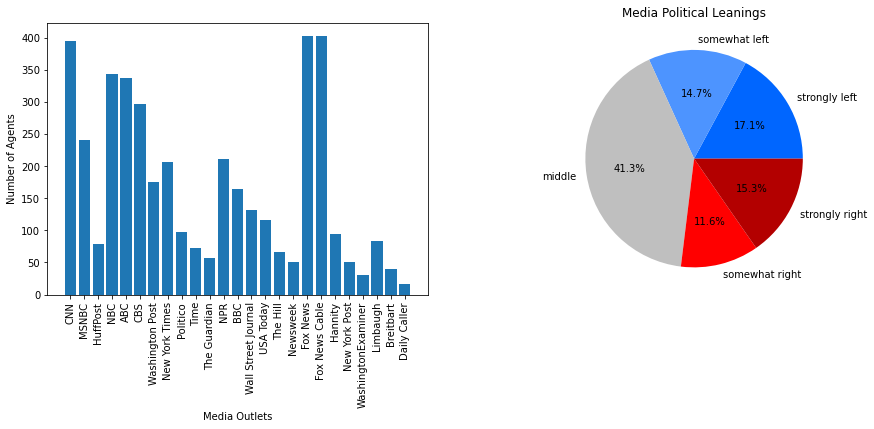

In [127]:
''' total = [44, 52]
3/18/20 Ipsos poll [44, 37, 10],
[[5, 56, 14],
[8, 30, 23],
[18, 7, 21],
[67, 5, 32],
[2, 1, 10]]
'''
model = Model(1000, [44, 37, 10],
                [[5, 56, 14],
                [8, 30, 23],
                [18, 7, 21],
                [67, 5, 32],
                [2, 1, 10]], 
              media_outlets, distribution_threshold=0.5, platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], 
              use_late_night=False)

''' total = [42, 52, 6]
4/22/20 Ipsos poll [44, 37, 10],
[[3, 54, 17],
[6, 26, 17],
[14, 6, 17],
[73, 7, 39],
[4, 7, 10]]
'''

''' total = [41, 54, 5]
5/20/20 Ipsos poll [44, 37, 10],
[[4, 55, 12],
[4, 27, 20],
[11, 6, 17],
[76, 7, 34],
[5, 5, 17]]
'''

model.media_landscape()

In [128]:
r = np.random.randint(1000)
model.agents[r].stats()
model.agents[r].consume_media()

Ideology: republican
Approval: somewhat approve
	Media Sources: Fox News, 
	Consumption Frequency: 1.5
Watches Late-Night: Never


[1]

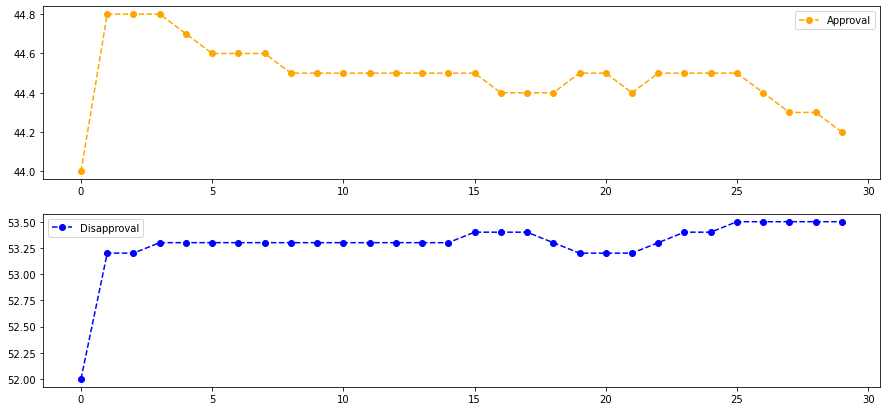

Average approval: -0.1014269076292664 -> -0.09960612433138646

Approval Percentages:  
	strongly approve: 25.7 -> 34.3% 
	somewhat approve: 18.3 -> 10.0% 
	somewhat disapprove: 14.4 -> 18.7% 
	strongly disapprove: 37.6 -> 34.7% 
	no opinion: 4.0 -> 2.3%

Overall Polling Change Predicted:
	Approve: 44.0% -> 44.3%
	Disapprove: 52.0% -> 53.4%


In [129]:
(threshold, alpha, persuadability_scale, social_media_const) = [0.37364163, 0.06361854, 0.4841436,  0.5254433 ]
late_night_const = -0.38006347
'''
Jokes/Day in Period 1: 4.202088452088452
Jokes/Day in Period 2: 4.8740165631469985
'''
late_night_jokes = 4.202088452088452

_ = model.simulate(30, draw=True, coverage_leaning=0, use_randomness=True, late_night_jokes=late_night_jokes,
               threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
               late_night_const=late_night_const, social_media_const=social_media_const)


C:\Users\samue\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\samue\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


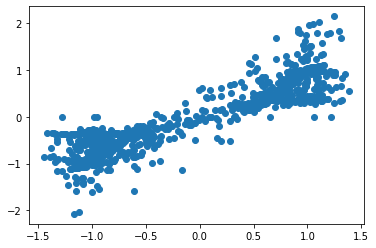

0.32777625556173384
0.8852516461586143


In [130]:
def estimate(t, x0, p, alpha, M, cl):
    f = np.math.factorial
    binom = 0
    expansion = 0
    for n in range(0, t+1):
        binom += f(t)*((-1)**(n)) * ((alpha * p)**n) / (f(n) * f(t-n))
        expansion += ((-1)**(n))*(t-n)*((alpha*p)**(n+1))*(M+cl)
    x = (binom)*x0 + expansion
    return x if not np.isnan(x) else 0
    
w = np.where([not model.agents[i].uses_social_media for i in range(len(model.agents))])

media_means = [np.mean(model.agents[i].consume_media()) for i in range(len(model.agents))]
alpha = 0.06361854
p = [abs(-np.sign(media_means[i])- model.starting_state[i])/2 for i in range(len(model.agents))]

est_approval = np.array([estimate(30, model.starting_state[i], p[i], alpha, media_means[i], 0) for i in range(len(model.agents))])
plt.scatter(model.agent_approval_values[w], est_approval[w])
plt.show()

print(np.mean(abs(model.agent_approval_values[w] - est_approval[w])))
print(np.corrcoef(model.agent_approval_values[w], est_approval[w])[0][1])


True

In [92]:
late_night_jokes = 4.8740165631469985
m.simulate(30, draw=True, coverage_leaning=-0.5, late_night_jokes=late_night_jokes,
               threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
               late_night_const=late_night_const, social_media_const=social_media_const)

NameError: name 'm' is not defined

## Optimize

In [141]:
#give model class and args as a tuple
def optimize(m, polling_target, bounds, initial_guess):
    #polling target should be the target approval rating
    #use scipy optimize or minimize to fit threshold and alpha
    coverage_leaning = 0.05
    
    #first period
    late_night_jokes = 4.202088452088452
    late_night_const=0
    def f(x):
        (threshold, alpha, persuadability_scale, social_media_const) = x
        
        result = m.simulate(30, optimize=True, use_randomness=True, coverage_leaning=coverage_leaning, late_night_jokes=late_night_jokes,
                            threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
                            social_media_const=social_media_const, late_night_const=late_night_const)
        loss = 0
        for i, r in enumerate(result):
            loss += abs(r - polling_target[i])**2
        loss /= len(result)
        
        return loss

    opt = differential_evolution(f, bounds=bounds, strategy='best1bin', disp=True, maxiter=50)
    #(threshold, alpha, persuadability_scale) = opt.x
    #m.simulate(30, draw=True, optimize=True, threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning)
        
    print(f'{[r for r in opt.x]}')
    return opt.x
    
    
    
    #return 
    #return minimize(f, initial_guess, bounds=bounds, method='Nelder-Mead')



In [136]:
def annealing(m, starting_pos):
    #starting_pos = (threshold, alpha, persuadability_scale, social_media_const, late_night_const)
    if starting_pos[-1] == 0:
        use_late_night = False
    else:
        use_late_night = True
        
    T = 1.0
    T_accept = 1e-7
    alpha = .999
    s = starting_pos
    while T > T_accept:
        s_new = randomNeighbor(s,use_late_night)
        cost_new = cost(m, s_new)
        cost_cur = cost(m, s)
        beta = betaFunc(cost_cur, cost_new, T)
        if cost_new < cost_cur:
            s = s_new
        else:
            if beta:
                s = s_new
        T = T * alpha
        print(f'\r Cost: {cost_cur},\t Beta: {beta},\t Temperature: {T}', end=' ', flush=True)
    return s

def randomNeighbor(s, use_late_night):
    #get random neighbor to the vector you are inputting
    if use_late_night:
        length = len(s)
    else:
        length = len(s)  - 1
    neighbor = np.zeros((length,))
    for i in range(length):
        neighbor[i] = np.random.normal(s[i], abs(np.log(s[i]+1))/3)
    return neighbor if use_late_night else np.append(neighbor, 0)

def cost(m, x):
    target = [42, 52, 6]
    coverage_leaning = 0.05
    
    #first period
    late_night_jokes = 4.202088452088452
    (threshold, alpha, persuadability_scale, social_media_const, late_night_const) = x

    result = m.simulate(30, optimize=True, use_randomness=True, coverage_leaning=coverage_leaning, late_night_jokes=late_night_jokes,
                        threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
                        social_media_const=social_media_const, late_night_const=late_night_const)
    loss = 0
    for i, r in enumerate(result):
        loss += abs(r - target[i])**2
    loss /= len(result)

    return loss 

def betaFunc(oldCost, newCost, T):
    delta = (oldCost - newCost)/(oldCost +newCost)
    P = np.exp(-delta/T)
    return np.random.uniform(0, 1) < P


In [124]:
args = (1000, [44, 37, 10],
            [[5, 56, 14],
            [8, 30, 23],
            [18, 7, 21],
            [67, 5, 32],
            [2, 1, 10]], media_outlets)

m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=False)

results = annealing(m, [0.23987374747543097, 0.008196967677699105, 0.19082355480732427, 0.15832773350644436, 0])
results

 Cost: 2.6666666666666665,	 Beta: True,	 Temperature: 0.4491491486100748  

KeyboardInterrupt: 

In [ ]:
#try just 3 targets   approve, disapprove, no op[0.21903605 0.00097886 0.5318334  0.00372754]
target = [42, 52, 6]



bounds = [(0.005, 0.5), (0.0005, 0.1), (0.0001, 1), (0, 1)]#, (-1, 0)]
#initial_guess = [ 0.3894822,   0.09130128,  0.84938691,  0.55262656, -0.38006347]
initial_guess = [0.23987374747543097, 0.008196967677699105, 0.19082355480732427, 0.15832773350644436]

args = (1000, [44, 37, 10],
            [[5, 56, 14],
            [8, 30, 23],
            [18, 7, 21],
            [67, 5, 32],
            [2, 1, 10]], media_outlets)

m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=False)

results = optimize(m, target, bounds, initial_guess)

differential_evolution step 1: f(x)= 1.5
differential_evolution step 2: f(x)= 1.04667
differential_evolution step 3: f(x)= 0.86
differential_evolution step 4: f(x)= 0.86
differential_evolution step 5: f(x)= 0.86
differential_evolution step 6: f(x)= 0.826667
differential_evolution step 7: f(x)= 0.506667
differential_evolution step 8: f(x)= 0.506667
differential_evolution step 9: f(x)= 0.506667
differential_evolution step 10: f(x)= 0.406667
differential_evolution step 11: f(x)= 0.326667
differential_evolution step 12: f(x)= 0.326667
differential_evolution step 13: f(x)= 0.326667
differential_evolution step 14: f(x)= 0.326667
differential_evolution step 15: f(x)= 0.326667
differential_evolution step 16: f(x)= 0.326667
differential_evolution step 17: f(x)= 0.326667
differential_evolution step 18: f(x)= 0.32
differential_evolution step 19: f(x)= 0.32
differential_evolution step 20: f(x)= 0.32
differential_evolution step 21: f(x)= 0.246667
differential_evolution step 22: f(x)= 0.246667
diffe

# Late Night

In [138]:
(threshold, alpha, persuadability_scale, social_media_const, late_night_const) = results#[ 0.00629773  0.07550578  0.39019542  0.78456869 -0.02043869]

'''
Jokes/Day in Period 1: 4.202088452088452
Jokes/Day in Period 2: 4.8740165631469985
'''
late_night_jokes = 4.202088452088452


LN_period1 = m.simulate(30, draw=False, use_randomness=True, coverage_leaning=0.05, late_night_jokes=late_night_jokes, use_starting_agents=True,
               threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
               late_night_const=late_night_const, social_media_const=social_media_const)


Average approval: -0.09419201093386209 -> -0.13064806676590246

Approval Percentages:  
	strongly approve: 26.1 -> 25.9% 
	somewhat approve: 17.9 -> 15.9% 
	somewhat disapprove: 15.3 -> 15.4% 
	strongly disapprove: 36.7 -> 36.7% 
	no opinion: 4.0 -> 6.1%

Overall Polling Change Predicted:
	Approve: 44.0% -> 41.8%
	Disapprove: 52.0% -> 52.1%


In [139]:
late_night_jokes = 4.8740165631469985
LN_period2 = m.simulate(30, draw=False, use_randomness=True, coverage_leaning=-0.25, late_night_jokes=late_night_jokes,
               threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
               late_night_const=late_night_const, social_media_const=social_media_const)

Average approval: -0.13064806676590246 -> -0.14679733177977308

Approval Percentages:  
	strongly approve: 25.9 -> 25.2% 
	somewhat approve: 15.9 -> 14.6% 
	somewhat disapprove: 15.4 -> 14.5% 
	strongly disapprove: 36.7 -> 38.0% 
	no opinion: 6.1 -> 7.7%

Overall Polling Change Predicted:
	Approve: 41.8% -> 39.8%
	Disapprove: 52.1% -> 52.5%


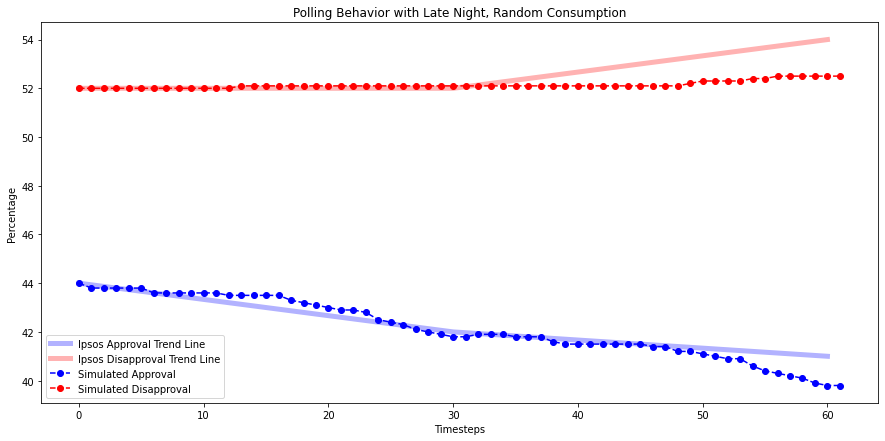

In [140]:
steps = range(62)
plt.figure(figsize=(15, 7))
plt.title("Polling Behavior with Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")

plt.plot([0, 30, 60], [44, 42, 41], label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot([0, 30, 60], [52, 52, 54], label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)

approval = np.concatenate((LN_period1, LN_period2))

plt.plot(steps, approval[:, 0], label="Simulated Approval", linestyle='--', marker='o', color='blue')
plt.plot(steps, approval[:, 1], label="Simulated Disapproval", linestyle='--', marker='o', color='red')
plt.legend()
plt.show()

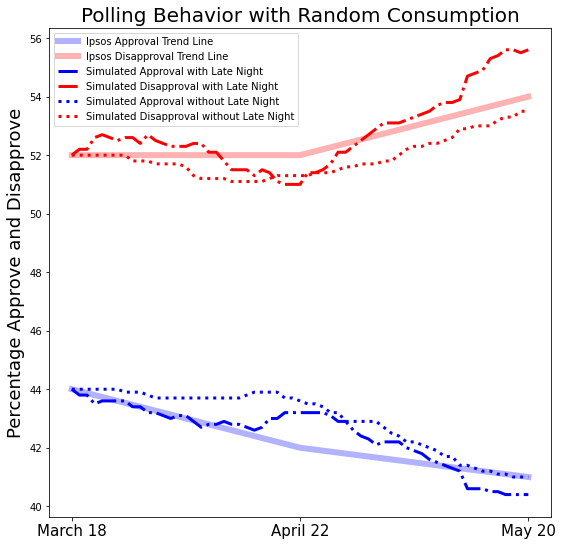

In [100]:
steps = range(61)
plt.figure(figsize=(9, 9))
plt.title("Polling Behavior with Random Consumption", fontsize=20)
#plt.xlabel("Timesteps", fontsize=20)
plt.xticks([0, 30, 60], labels=['March 18', 'April 22', 'May 20'], fontsize=15)
plt.ylabel("Percentage Approve and Disapprove", fontsize=18)

plt.plot([0, 30, 60], [44, 42, 41], label='Ipsos Approval Trend Line', color='blue', lw=6, alpha=0.3)
plt.plot([0, 30, 60], [52, 52, 54], label='Ipsos Disapproval Trend Line', color='red', lw=6, alpha=0.3)

LN = np.concatenate((LN_period1, LN_period2[1:]))
NLN = np.concatenate((NLN_period1, NLN_period2[1:]))

plt.plot(steps, LN[:, 0], label="Simulated Approval with Late Night", linestyle='-.',  color='blue', lw=3)
plt.plot(steps, LN[:, 1], label="Simulated Disapproval with Late Night", linestyle='-.',  color='red', lw=3)

plt.plot(steps, NLN[:, 0], label="Simulated Approval without Late Night", linestyle=':',  color='blue', lw=3)
plt.plot(steps, NLN[:, 1], label="Simulated Disapproval without Late Night", linestyle=':', color='red', lw=3)

plt.legend()
plt.show()

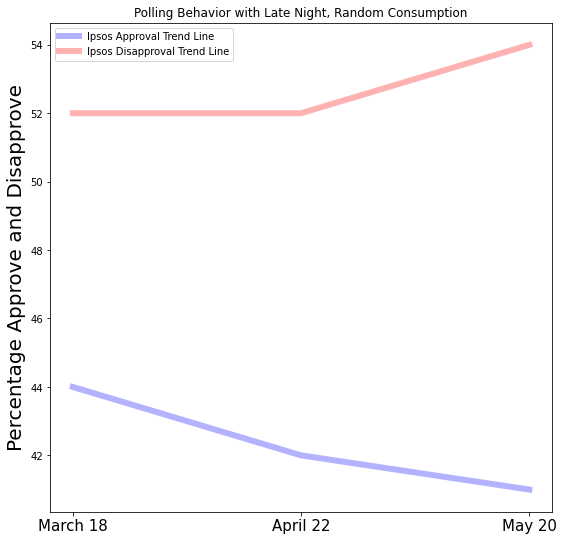

In [96]:
steps = range(61)
plt.figure(figsize=(9, 9))
plt.title("Polling Behavior with Late Night, Random Consumption")
#plt.xlabel("Timesteps", fontsize=20)
plt.xticks([0, 30, 60], labels=['March 18', 'April 22', 'May 20'], fontsize=15)
plt.ylabel("Percentage Approve and Disapprove", fontsize=20)

plt.plot([0, 30, 60], [44, 42, 41], label='Ipsos Approval Trend Line', color='blue', lw=6, alpha=0.3)
plt.plot([0, 30, 60], [52, 52, 54], label='Ipsos Disapproval Trend Line', color='red', lw=6, alpha=0.3)


plt.legend()
plt.show()

# No Late Night

In [133]:
(threshold, alpha, persuadability_scale, social_media_const) = results#[0.37364163, 0.06361854, 0.4841436,  0.5254433 ]

late_night_jokes = 4.202088452088452
late_night_const = 0

NLN_period1 = m.simulate(30, draw=False, use_randomness=True, coverage_leaning=0.25, late_night_jokes=late_night_jokes, use_starting_agents=True,
               threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
               late_night_const=late_night_const, social_media_const=social_media_const)


Average approval: -0.1089896177164236 -> -0.09833004018667112

Approval Percentages:  
	strongly approve: 25.5 -> 28.2% 
	somewhat approve: 18.5 -> 14.4% 
	somewhat disapprove: 14.2 -> 11.8% 
	strongly disapprove: 37.8 -> 39.6% 
	no opinion: 4.0 -> 6.0%

Overall Polling Change Predicted:
	Approve: 44.0% -> 42.6%
	Disapprove: 52.0% -> 51.4%


In [134]:
late_night_jokes = 4.8740165631469985
NLN_period2 = m.simulate(30, draw=False, use_randomness=True, coverage_leaning=-0.75, late_night_jokes=late_night_jokes,
               threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, 
               late_night_const=late_night_const, social_media_const=social_media_const)

Average approval: -0.09833004018667112 -> -0.11581419617287082

Approval Percentages:  
	strongly approve: 28.2 -> 28.2% 
	somewhat approve: 14.4 -> 13.7% 
	somewhat disapprove: 11.8 -> 11.4% 
	strongly disapprove: 39.6 -> 40.3% 
	no opinion: 6.0 -> 6.4%

Overall Polling Change Predicted:
	Approve: 42.6% -> 41.9%
	Disapprove: 51.4% -> 51.7%


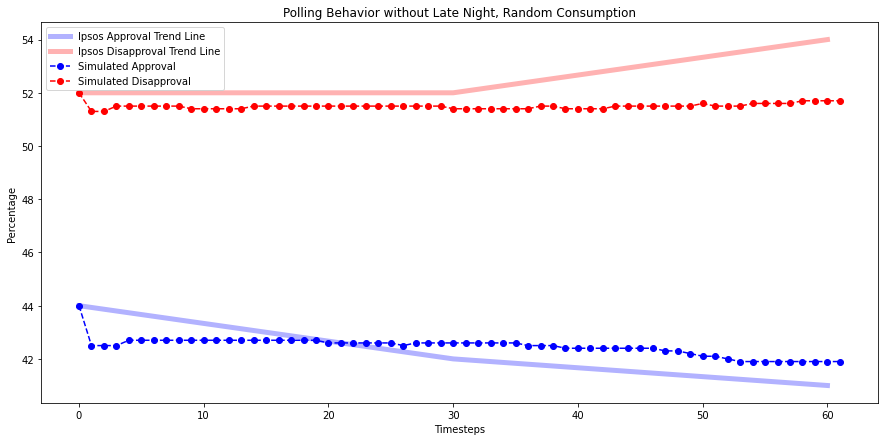

In [135]:
steps = range(62)
plt.figure(figsize=(15, 7))
plt.title("Polling Behavior without Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")

plt.plot([0, 30, 60], [44, 42, 41], label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot([0, 30, 60], [52, 52, 54], label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)

approval = np.concatenate((NLN_period1, NLN_period2))

plt.plot(steps, approval[:, 0], label="Simulated Approval", linestyle='--', marker='o', color='blue')
plt.plot(steps, approval[:, 1], label="Simulated Disapproval", linestyle='--', marker='o', color='red')
plt.legend()
plt.show()

In [114]:
np.append([0, 1, 2], 8)

array([0, 1, 2, 8])